In [ ]:
"""
Introduction to Artificial Intelligence, Exercise 5:
Neural networks.
Authors: 
    Robert Kaczmarski 293377
    Damian Łysomirski 293365
"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [75]:
x, y = fetch_openml('mnist_784', version=1, cache = True, return_X_y=True)

In [76]:
# normalize values to [0, 1] range
x = (x/255).astype('float32')

In [77]:
# change to categorical representation
# example: y[0]=5 change to y[0]=[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
new_y = np.zeros((70000, 10), dtype='float32')
for i, n in enumerate(y):
  new_y[i][int(n)] = 1 


In [78]:
train_data, test_data, train_labels, test_labels = train_test_split(x, new_y, test_size=0.143, random_state=1)

In [82]:
class NeuralNetwork:
    """Class that setups and initializes network.

    Attributes:
        dimension (list[int]): determine the dimensions of the individual layers
        layers (int): number of layers
        epochs (int): number of epochs
        lerning_rate: sets the speed at which the network will learn
        parameters (dict): holds W, b, Z, A
    
    """

    def __init__(self, dimensions, epochs=10, lerning_rate = 0.01) -> None:
        self.dimensions = dimensions
        self.layers = len(self.dimensions)
        self.epochs = epochs
        self.lerning_rate = lerning_rate
        self.parameters = self.initialize()
    
    def initialize(self):
        """Initialize weigths and biases with random value from normal distribution."""
        np.random.seed(1)
        parameters = {}

        for i in range(1, self.layers):
            parameters['W'+str(i)] = np.random.randn(self.dimensions[i], self.dimensions[i-1])
            parameters['b'+str(i)] = np.random.randn(self.dimensions[i])
  
        return parameters

    def forward_propagation(self, input):
        """Forward pass through the neural network."""
        params = self.parameters
        params['A0'] = input

        for i in range(1, self.layers-1):
            params['Z'+str(i)] = np.matmul(params['W'+str(i)], params['A'+str(i-1)]) + params['b'+str(i)]
            params['A'+str(i)] = self.sigmoid(params['Z'+str(i)])
        
        params['Z'+str(self.layers-1)] = np.matmul(params['W'+str(self.layers-1)], params['A'+str(self.layers-2)]) + params['b'+str(self.layers-1)]
        params['A'+str(self.layers-1)] = self.softmax(params['Z'+str(self.layers-1)])

        return params['A'+str(self.layers-1)]

    def backward_propagation(self, y, output):
        """Backward propagation with calculating changes to weights and biases.
        
        Note:
            d_error is derivative of MSE error. MSE = (output - y)^2
        """
        params = self.parameters
        change = {}

        d_error = 2 * (output - y) / output.shape[0] * self.dsoftmax(params['Z'+str(self.layers-1)])
        change['W'+str(self.layers-1)] = np.outer(d_error, params['A'+str(self.layers-2)])
        change['b'+str(self.layers-1)] = d_error

        for i in range(self.layers-2, 0, -1):
            d_error = np.matmul(params['W'+str(i+1)].T, d_error) * self.dsigmoid(params['Z'+str(i)])
            change['W'+str(i)] = np.outer(d_error, params['A'+str(i-1)])
            change['b'+str(i)] = d_error

        return change

    def update_params(self, changes):
        """Update weights and biases.

            w = w - lerning_rate*gradient(dC/dw)
            b = b - lerning_rate*gradient(dC/db)
            where C is MSE cost function.
        """
        for key, value in changes.items():
            self.parameters[key] -= self.lerning_rate * value

    def train(self, train_data, train_labels, test_data, test_labels):
        """Method for training model."""
        mse = []

        for epoch in range(self.epochs):
            for x, y in zip(train_data, train_labels):
                output = self.forward_propagation(x)
                mse.append((output - y)**2)
                param_changes = self.backward_propagation(y, output)
                self.update_params(param_changes)

            print(f"MSE = {np.mean(mse)}")
            accuracy = self.accuracy(test_data, test_labels)
            print(f'Epoch: {epoch+1}, , Accuracy: {accuracy*100:.2f}%')

    def sigmoid(self, z):
        """Activation function."""
        return 1 / (1 + np.exp(-z))
    
    def dsigmoid(self, z):
        """Derivative of sigmoid activation function."""
        sigm = self.sigmoid(z)
        # return (np.exp(-z))/((np.exp(-z)+1)**2)
        return sigm * (1 - sigm)
    
    def softmax(self, x):
        """Function converts a vector of K real values into a vector of K real values that sum to 1."""
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def dsoftmax(self, x):
        """Derivative of softmax function."""
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))

    def accuracy(self, data, labels):
        '''Accuracy of prediction in epoch.'''
        predictions = []

        for x, y in zip(data, labels):
            output = self.forward_propagation(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)
      
    def confusion_matrix(self, data, labels):
        """Calculate confusion matrix values."""
        conf_mat = []
        temp_dict = {}

        for i in range(0, 10):
            temp_dict[i] = 0
        for _ in range(0, 10):
            conf_mat.append(temp_dict.copy())

        for x, y in zip(data, labels):
            output = self.forward_propagation(x)
            pred = np.argmax(output)
            correct = np.argmax(y)
            conf_mat[correct][pred] += 1
        
        return conf_mat
    
    def get_examples(self, test_data, test_labels, correct, number):
        """Get test examples to display correctness of classification"""
        examples = []
        for x, y in zip(test_data, test_labels):
            output = self.forward_propagation(x)
            prediction = np.argmax(output)
            expected = np.argmax(y)
            res = (prediction == expected)

            if res == correct:
                print("app")
                examples.append((prediction, expected, x))

            if len(examples) == number:
                print("break")
                break

        return examples

In [83]:
def display_confucion_matrix(confusion_matrix):
    """Simple function for displaying the error matrix."""
    predicted = "predicted"
    expected = "expected"
    print("Confuse matrix:\n")
    print("  ", end=" ")
    for e in expected:
        print(e, end="   ")
    print("")
    print("   0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9")
    for i, x in enumerate(zip(*list(dic.values() for dic in confusion_matrix))):
        if i < len(predicted):
            print(predicted[i], i, x)
        else:
            print(" ", i, x)

In [84]:
# input dimension is 28x28=784, output=10
dimensions = [784, 256, 10]
epochs = 15
lerning_rate = 0.01

In [85]:
nn = NeuralNetwork(dimensions, epochs, lerning_rate)
nn.train(np.array(train_data), train_labels, np.array(test_data), test_labels)

MSE = 0.12666408756544897
Epoch: 1, , Accuracy: 35.69%
MSE = 0.1085900033221518
Epoch: 2, , Accuracy: 46.64%
MSE = 0.09634985737557493
Epoch: 3, , Accuracy: 54.87%
MSE = 0.08716246904043391
Epoch: 4, , Accuracy: 60.88%
MSE = 0.08012056549213047
Epoch: 5, , Accuracy: 64.90%
MSE = 0.07452482429521995
Epoch: 6, , Accuracy: 68.04%
MSE = 0.0699033772497996
Epoch: 7, , Accuracy: 71.14%
MSE = 0.06599846576335498
Epoch: 8, , Accuracy: 73.27%
MSE = 0.06265073497059864
Epoch: 9, , Accuracy: 75.01%
MSE = 0.05974825338300937
Epoch: 10, , Accuracy: 76.82%
MSE = 0.0572063439384956
Epoch: 11, , Accuracy: 78.04%
MSE = 0.05496014695489045
Epoch: 12, , Accuracy: 79.17%
MSE = 0.05295945068634481
Epoch: 13, , Accuracy: 79.90%
MSE = 0.051164447126472376
Epoch: 14, , Accuracy: 80.56%
MSE = 0.049543207420541725
Epoch: 15, , Accuracy: 80.96%


In [86]:
examples_correct = nn.get_examples(np.array(test_data), test_labels, True, 2)
examples_wrong = nn.get_examples(np.array(test_data), test_labels, False, 10)

app
app
break
app
app
app
app
app
app
app
app
app
app
break


Prediction: 6, Expectation: 6
Prediction: 2, Expectation: 2


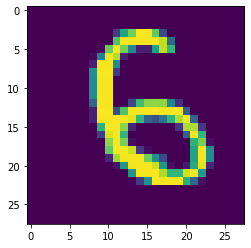

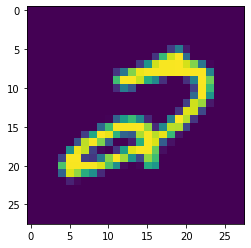

In [88]:
print(f"Prediction: {examples_correct[0][0]}, Expectation: {examples_correct[0][1]}")
plt.figure(0)
plt.imshow(examples_correct[0][2].reshape((28,28))*255)
print(f"Prediction: {examples_correct[1][0]}, Expectation: {examples_correct[1][1]}")
plt.figure(1)
plt.imshow(examples_correct[1][2].reshape((28,28))*255)

Prediction: 9, Expectation: 7


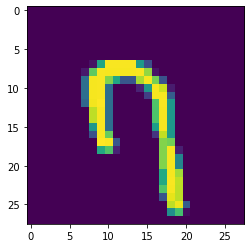

In [89]:
i = 5
print(f"Prediction: {examples_wrong[i][0]}, Expectation: {examples_wrong[i][1]}")
plt.figure(i)
plt.imshow(examples_wrong[i][2].reshape((28,28))*255)

In [90]:
confuse_matrix = nn.confusion_matrix(np.array(test_data), test_labels)

In [91]:
display_confucion_matrix(confuse_matrix)

Confuse matrix:

   e   x   p   e   c   t   e   d   
   0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
p 0 (852, 0, 19, 19, 3, 32, 14, 12, 12, 6)
r 1 (2, 1126, 16, 8, 3, 13, 12, 14, 19, 6)
e 2 (9, 12, 836, 45, 10, 21, 25, 22, 25, 11)
d 3 (19, 16, 31, 781, 11, 77, 5, 4, 68, 22)
i 4 (5, 3, 29, 5, 785, 18, 25, 27, 24, 110)
c 5 (28, 10, 15, 78, 7, 642, 23, 8, 58, 13)
t 6 (19, 3, 27, 11, 15, 37, 820, 3, 19, 5)
e 7 (10, 0, 21, 20, 14, 13, 3, 892, 12, 85)
d 8 (5, 11, 35, 50, 13, 61, 8, 18, 667, 29)
  9 (11, 6, 7, 18, 81, 17, 7, 51, 32, 703)
